In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import math

import cv2
from google.colab.patches import cv2_imshow
from keras.regularizers import l2
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.engine.training import Model
from keras import backend as K, regularizers
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Add, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
import scipy.io as sio
from keras.utils import to_categorical
import keras.models

In [ ]:
# IMPORTANT! READ THIS!
# Must manually import these following 2 files from the drive folder
# Simply download files to local pc and upload to colab runtime
# 8x8_mask.png
# 32x32_white.jpg

In [ ]:
%%shell
rm -rf *
wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1mbkgkpRXeUDwTxVjxdSkkFUGrzr62bVd' -O 8x8_mask.png
wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1mMqJCzdQDEv2O4dESOghX7GGaf30cthc' -O 32x32_white.jpg
# getting the keras_model direc zipped file (>100 MB through wget)
wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Dki6AJan6sthZy9lfDWtvms3GN8rJPKW' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Dki6AJan6sthZy9lfDWtvms3GN8rJPKW" -O keras_model.zip && rm -rf /tmp/cookies.txt
# unzip under /content/ directory
unzip -q keras_model.zip

In [ ]:
# Get SVHN dataset
transform = transforms.ToTensor()
svhn_data = torchvision.datasets.SVHN(root="data", split="train", transform=transform, download=True)

In [ ]:
# Save 1000 samples in runtime
for i in range(40):
    if i % 2 == 0:
        save_image(svhn_data[i][0], str(int(i/2)) + ".jpg")

In [ ]:
# OpenCV Image Inpainting
mask = cv2.imread('8x8_mask.png',0)
images = []
for i in range(20):
    img = cv2.imread(str(i) + ".jpg")
    dst = cv2.inpaint(img, mask, 3, cv2.INPAINT_TELEA)
    images.append(dst)

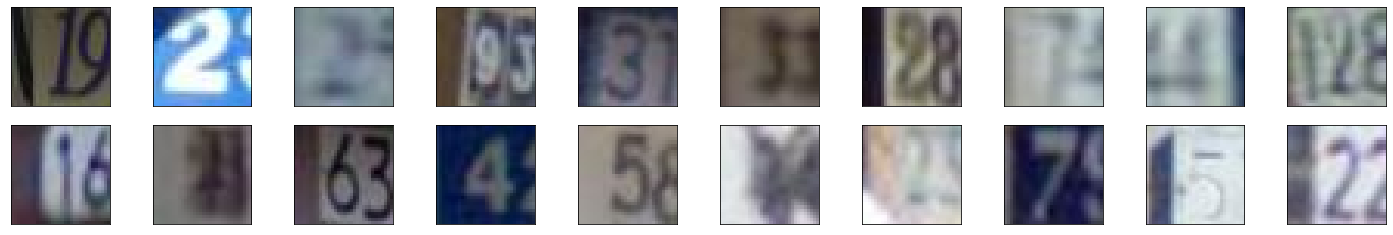

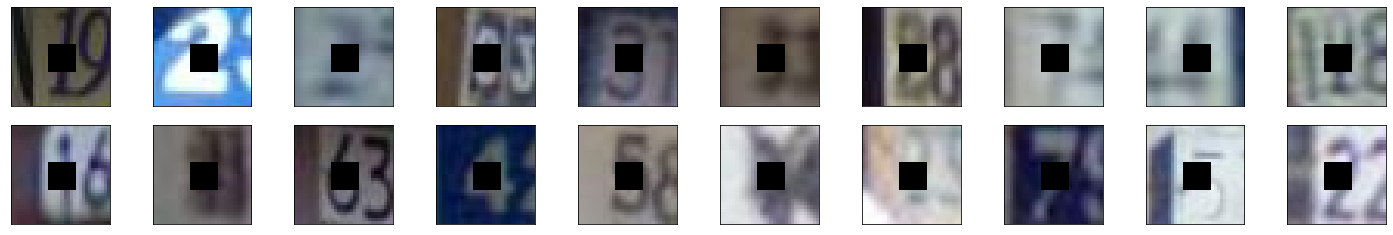

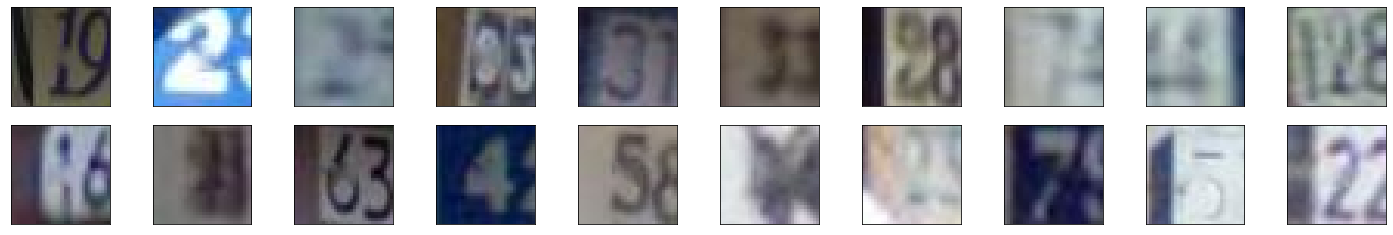

In [ ]:
# Plot the 20 original images from the dataset
fig = plt.figure(figsize=(25, 4))
for idx in range(20):
    img = cv2.imread (str(idx) + '.jpg')
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Plot the 20 images with mask applied
base = cv2.imread('32x32_white.jpg',0)
mask_sample = cv2.rectangle(base, (12,12), (20,20), (0,0,0), -1)
fig = plt.figure(figsize=(25, 4))
for idx in range(20):   
    img = cv2.imread (str(idx) + '.jpg')
    base = cv2.imread('32x32_white.jpg',0)
    mask_sample = cv2.rectangle(base, (12,12), (20,20), (0,0,0), -1)
    res = cv2.bitwise_and(img,img,mask = mask_sample)
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))

# Plot the 20 inpainted images by openCV
fig = plt.figure(figsize=(25, 4))
for idx in range(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(cv2.cvtColor(images[idx], cv2.COLOR_BGR2RGB))

In [ ]:
mask = cv2.imread('6x6_mask.png',0)
image = []
label = []

for i in range(5):
    save_image(svhn_data[i][0], str(i) + ".jpg")
    img = cv2.imread(str(i) + ".jpg")
    dst = cv2.inpaint(img, mask, 3, cv2.INPAINT_TELEA)
    image.append(dst)
    label.append(svhn_data[i][1])

In [ ]:
image_tensor = torch.Tensor(image)
label_tensor = torch.Tensor(label)

dataset = torch.utils.data.TensorDataset(image_tensor, label_tensor)
dataloader = torch.utils.data.DataLoader(dataset)

In [ ]:
loaded_model = keras.models.load_model('/content/keras_model')

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
# applying transformation to image
train_gen = ImageDataGenerator(
   rotation_range=15,
   zoom_range = 0.10,
   width_shift_range=0.3,
   height_shift_range=0.3,
   brightness_range=[0.2,1.0]
)

In [ ]:
def get_accuracy_keras (data_loader, batch_size, verbose=False):
    '''
    get accuracy by randomly selecting 10 batches from the data_loader to speed up the training
    '''
    loss, accuracy = 0.0, 0.0
    samples = 0
    for i, (d_images, labels) in enumerate(data_loader):
    
        #KERAS part
        images = d_images.cpu().detach().numpy()
        labels = labels.cpu().detach().numpy()
        one_hot_labels = to_categorical(labels, 10)
        # images = np.transpose(images, (0, 2, 3, 1))
        # Converting the arrays to Float type
        images = images.astype('float32')
        # Normalizing
        images = images / 255.0
        keras_batch = train_gen.flow(images, one_hot_labels, batch_size=batch_size)
        new_loss, new_accuracy = loaded_model.evaluate(keras_batch, verbose=verbose)

        loss += new_loss
        accuracy += new_accuracy
        samples += 1

    print(f'sample count: {samples}')
    return loss/samples, accuracy/samples

In [ ]:
loss, acc = get_accuracy_keras(dataloader, batch_size=1)
print(loss)
print(acc)

In [ ]:
blocked_image = []
blocked_label = []
for idx in range(1000):
    save_image(svhn_data[i][0], str(i) + ".jpg")
    img = cv2.imread (str(idx) + '.jpg')
    base = cv2.imread('32x32_white.jpg',0)
    mask_sample = cv2.rectangle(base, (12,12), (20,20), (0,0,0), -1)
    res = cv2.bitwise_and(img,img,mask = mask_sample)
    blocked_image.append(res)
    blocked_label.append(svhn_data[i][1])

In [ ]:
blocked_image_tensor = torch.Tensor(blocked_image)
blocked_label_tensor = torch.Tensor(blocked_label)

blocked_dataset = torch.utils.data.TensorDataset(blocked_image_tensor, blocked_label_tensor)
blocked_dataloader = torch.utils.data.DataLoader(blocked_dataset)

In [ ]:
blocked_loss, blocked_acc = get_accuracy_keras(blocked_dataloader, batch_size=1)
print(blocked_loss)
print(blocked_acc)